## Eisenhower Tunnel
The following script examines traffic data at the Eisenhower tunnel on I70 East of Denver is Colorado, USA. 


If you are unfamiliar with the tunnel see the Wiki article here
https://en.wikipedia.org/wiki/Eisenhower_Tunnel


We will load the data for across multiple months and years but this is an example of how the monthly data are presented on the CDOT webpage.

#### Example Data fora  single month
https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

### Load Primary Packages

In [429]:
#Load pertinent packages

#https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

import os
import sys
import time
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict


import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns


### Data Scraping

We will be working with hourly count data collected by CDOT (Colorado Dept of Transport) at numerous stations across Colorado.  We will be examining the station at the Eisehower tunnel. Data are stored with one column per hour and one row per day for each month. As written the script will pull just over 3 years of data.

In [3]:
# specify stations and dates of interest

# url to format: station ID, year, month
url =  "https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/{}/true/{}/{}"


#station '000106' is on the eisenhower tunnel I70
stations = ['000106']


# period of interest
years=['2017', '2018','2019','2020','2021']
months= range(1, 13)



### Define web scraping function
define function to pull hourly data for months and years of interest for the Eisenhower station ('000106').

In [4]:
#define function to pull hourly data for months and years of interest
def get_data(url, station_entry, year_entry, month_entry):
     data =[]                    
   
     for station in station_entry:
        for year in year_entry:
            for month in month_entry:
                r2=requests.get(url.format(station,year,month))
                df_list2 = pd.read_html(r2.text, skiprows=0)
                df2=df_list2[0]  #confirmed type is pd.df
                data.append(df2)                             
                
        return data 
        
station=get_data(url,stations,years,months)  



#pd.DataFrame(final)
# Examine first few rows of the data frame.
traffic_pd=pd.concat(station, axis=0)
traffic_pd.head()

# this may take 30 seconds to a  minute.

Count Date Dir   0h  1h   2h  3h   4h   5h   6h    7h    8h    9h   10h  \
0  01/01/2017   P   94  75   84  91  131  237  477   721  1061  1694  2593   
1  01/01/2017   S   77  95   77  68   80  157  389  1221  1304  1158  1328   
2  01/02/2017   P  123  84  108  99  177  348  628   989  1454  2076  2687   
3  01/02/2017   S   98  91   82  91  118  202  590  1512  1826  1719  1760   
4  01/03/2017   P  115  83   59  99   92  265  484   724  1002   865  1195   

    11h   12h   13h   14h   15h   16h   17h   18h   19h  20h  21h  22h  23h  
0  2739  2686  2335  2208  1995  1985  1608  1292  1070  755  499  304  181  
1  1460  1500  1481  1467  1379  1221   965   855   804  550  356  270  176  
2  2599  2505  2482  2621  1505  2107  2246  1565  1098  793  387  236  123  
3  1932  1753  1462  1292  1338  1210   822   544   450  410  353  264  150  
4  1191   981  1105  1590  1208  1309  1118   533   186    9   10   10   12

In [5]:
# transform wide data to long

traffic_long = traffic_pd.melt(
    id_vars=['Count Date', 'Dir'],
    var_name='hour', value_name='vehicles_per_hour')


traffic_long['hour']=traffic_long['hour'].replace("h", "",regex=True)
traffic_long['hour']=traffic_long['hour'].astype('int')

#change vehicles to integer
traffic_long['vehicles_per_hour']=traffic_long['vehicles_per_hour'].astype('int')

# Specify input format
traffic_long["Count Date"] =  pd.to_datetime(traffic_long["Count Date"], format="%m/%d/%Y")
#traffic_long["Dir"] =  traffic_long['Dir'].astype("S")

#rename columns
traffic_long=traffic_long.rename(columns={"Count Date": "count_date", "Dir": "direction"})

#sort by date, hour
traffic_long = traffic_long.sort_values(by = ['count_date' ,'hour'])
traffic_long=traffic_long.reindex( )

#print main features
traffic_long.dtypes

#Data dimensions
print( "The extracted data have the following dimensions" +  str(traffic_long.shape))

#print first few rows
traffic_long.head()

The extracted data have the following dimensions(82152, 4)


count_date direction  hour  vehicles_per_hour
0    2017-01-01         P     0                 94
1    2017-01-01         S     0                 77
3423 2017-01-01         P     1                 75
3424 2017-01-01         S     1                 95
6846 2017-01-01         P     2                 84

### Quality check
Examine data for missing values and 5 point summaries

In [6]:


# count missing values in each column
print(traffic_long.isnull().sum())

#Check total counts
traffic_long.count()


count_date           0
direction            0
hour                 0
vehicles_per_hour    0
dtype: int64


count_date           82152
direction            82152
hour                 82152
vehicles_per_hour    82152
dtype: int64

In [7]:
#Check range of values
def min_max(df,col):
    max_value=df[col].max()
    min_value=df[col].min()
    print(min_value,max_value)
    
    
min_max(traffic_long, 'count_date')    
#
min_max(traffic_long, 'vehicles_per_hour')



2017-01-01 00:00:00 2021-12-31 00:00:00
0 5625


### Summary
Examine data for missing values and 5 point summaries

In [8]:
# calculate a 5-number summary of traffic data
from numpy import percentile
from numpy.random import rand
# generate data sample
# calculate quartiles
quartiles = percentile(traffic_long['vehicles_per_hour'], [25, 50, 75])
# calculate min/max
data_min, data_max = traffic_long['vehicles_per_hour'].min(), traffic_long['vehicles_per_hour'].max()
# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.000
Q1: 178.000
Median: 602.000
Q3: 1125.000
Max: 5625.000


In [9]:
hourly_traffic=traffic_long


Data are in good shape. 2017 appears to have some missing dates


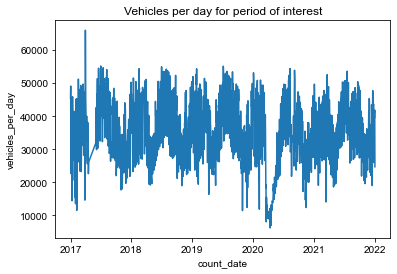

In [10]:
# Calculate daily sums regardless of direction to QC plot
daily_traffic = traffic_long.groupby('count_date').sum()
daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})

# Plot all time
sns.lineplot(data=daily_traffic, x="count_date", y="vehicles_per_day").set(
    title="Vehicles per day for period of interest")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(18,10)})
#Plot standardized to day of year


print("Data are in good shape. 2017 appears to have some missing dates")



### Identify missing rows
Missing dates are missing entirely with no row for the missing day and hour.  The following section will create one row for hour between the start and end of our period of interest. 

In [11]:
#View the existing data frame
hourly_traffic.head()

count_date direction  hour  vehicles_per_hour
0    2017-01-01         P     0                 94
1    2017-01-01         S     0                 77
3423 2017-01-01         P     1                 75
3424 2017-01-01         S     1                 95
6846 2017-01-01         P     2                 84

In [12]:
# create hourly data frame, duplicate for direction, join with true data
start=hourly_traffic['count_date'].min()
end=hourly_traffic['count_date'].max()

hourly_rows = pd.DataFrame(
        {'count_datetime': pd.date_range(start, end, freq='1H', closed='left')}
     )
hourly_rows['temp']=1
print(len(hourly_rows)*2)
hourly_rows.head()

87600


count_datetime  temp
0 2017-01-01 00:00:00     1
1 2017-01-01 01:00:00     1
2 2017-01-01 02:00:00     1
3 2017-01-01 03:00:00     1
4 2017-01-01 04:00:00     1

In [13]:
direction = [['P'], ['S']]
 
# Create the pandas DataFrame
direction = pd.DataFrame(direction, columns = ['direction'])
direction['temp']=1
direction.head()

direction  temp
0         P     1
1         S     1

In [14]:
hourly_rows_empty =pd.merge(
                   hourly_rows,
                   direction,
                   how="left",
                   on='temp')

hourly_rows_empty=hourly_rows_empty.drop('temp', axis=1)
print(len(hourly_rows_empty))


#print first few rows
hourly_rows_empty.head(6)

87600


count_datetime direction
0 2017-01-01 00:00:00         P
1 2017-01-01 00:00:00         S
2 2017-01-01 01:00:00         P
3 2017-01-01 01:00:00         S
4 2017-01-01 02:00:00         P
5 2017-01-01 02:00:00         S

In [15]:
#check data type
hourly_rows_empty.dtypes

count_datetime    datetime64[ns]
direction                 object
dtype: object

In [16]:

#add hours to datetime ahead of join
hourly_traffic['count_datetime']= hourly_traffic['count_date'] + pd.to_timedelta(hourly_traffic['hour'], unit='h').copy()

hourly_traffic.head()


count_date direction  hour  vehicles_per_hour      count_datetime
0    2017-01-01         P     0                 94 2017-01-01 00:00:00
1    2017-01-01         S     0                 77 2017-01-01 00:00:00
3423 2017-01-01         P     1                 75 2017-01-01 01:00:00
3424 2017-01-01         S     1                 95 2017-01-01 01:00:00
6846 2017-01-01         P     2                 84 2017-01-01 02:00:00

In [17]:
hourly_traffic_full = pd.merge(hourly_rows_empty, hourly_traffic, how='left', on=['count_datetime', 'direction'])

hourly_traffic_full.head()

count_datetime direction count_date  hour  vehicles_per_hour
0 2017-01-01 00:00:00         P 2017-01-01   0.0               94.0
1 2017-01-01 00:00:00         S 2017-01-01   0.0               77.0
2 2017-01-01 01:00:00         P 2017-01-01   1.0               75.0
3 2017-01-01 01:00:00         S 2017-01-01   1.0               95.0
4 2017-01-01 02:00:00         P 2017-01-01   2.0               84.0

We now have a complete data frame with one row per hour from the start to end of our period of interest. There are ~5500 rows will null traffic counts.

In [18]:

# check for missing values
print(hourly_traffic_full.isnull().sum())

count_datetime          0
direction               0
count_date           5496
hour                 5496
vehicles_per_hour    5496
dtype: int64


In [54]:
# Recalculate count date column to fill in missing values
hourly_traffic_full['count_date'] =  pd.to_datetime(pd.to_datetime(hourly_traffic_full['count_datetime']).dt.date)

#get hour from count_date time
hourly_traffic_full['hour'] = hourly_traffic_full['count_datetime'].dt.hour

# flag missing rows. We will track imputed rows
# True are measured, false will be imputed using the mean for a given weak
hourly_traffic_full['measured']=hourly_traffic_full['vehicles_per_hour'].notna()



#add month,week,day for imputing
hourly_traffic_full['month']=hourly_traffic_full['count_date'].dt.month
hourly_traffic_full['week']=hourly_traffic_full['count_date'].dt.isocalendar().week
hourly_traffic_full['day']=hourly_traffic_full['count_date'].dt.day_of_week

hourly_traffic_full.head()


count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2017-01-01 00:00:00         P 2017-01-01     0               94.0      True   
1 2017-01-01 00:00:00         S 2017-01-01     0               77.0      True   
2 2017-01-01 01:00:00         P 2017-01-01     1               75.0      True   
3 2017-01-01 01:00:00         S 2017-01-01     1               95.0      True   
4 2017-01-01 02:00:00         P 2017-01-01     2               84.0      True   

   month  week  day  
0      1    52    6  
1      1    52    6  
2      1    52    6  
3      1    52    6  
4      1    52    6

In [55]:
hourly_traffic_full['vehicles_per_hour'] = hourly_traffic_full.groupby(['month', 'day','hour', 'direction'])['vehicles_per_hour']\
    .transform(lambda x: x.fillna(x.mean()))

#print null counts
print(hourly_traffic_full.isnull().sum())

count_datetime       0
direction            0
count_date           0
hour                 0
vehicles_per_hour    0
measured             0
month                0
week                 0
day                  0
dtype: int64


In [24]:
# check first few rows
hourly_traffic_full.head()

count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2017-01-01 00:00:00         P 2017-01-01     0               94.0      True   
1 2017-01-01 00:00:00         S 2017-01-01     0               77.0      True   
2 2017-01-01 01:00:00         P 2017-01-01     1               75.0      True   
3 2017-01-01 01:00:00         S 2017-01-01     1               95.0      True   
4 2017-01-01 02:00:00         P 2017-01-01     2               84.0      True   

   month  week  day  
0      1    52    6  
1      1    52    6  
2      1    52    6  
3      1    52    6  
4      1    52    6

In [25]:
# Bring in the weather data. fill in missing values

## Weather Data

Traffic counts and delays are closely related to road conditions. Eisenhower Tunnel is at 11,158' ft elevation and 26 ft (~8 m) annual snowfall. Recent snowfall has the potential to adjust the behavior of drivers; drivers may wait for roads to be cleared or may take the opportunity to ski fresh snow.  The next portion will bring in the weather data, check for nulls, confirm data have the proper data types, and join with the traffic data.  We will be working with hourly weather data sampled to the dates in our current data set. 

We will be shifting our focus to preparing weather data before combining the two data sources.

In [56]:
from datetime import datetime



In [93]:
# Import Meteostat library and dependencies
from datetime import datetime
import meteostat 
from meteostat import Point, Hourly
from meteostat import Stations

# data dictionary can be found here:
#https://dev.meteostat.net/python/hourly.html

# set station coordinates and pull data using "fetch"
stations = Stations()
stations = stations.nearby(39.6787, -105.9194)  # Eisenhower Tunnel
station = stations.fetch(1)


# print station
print("Weather Station name")
print(station.iloc[0:4, 0:4].transpose())

print("############")

print("station data types")
print(station.dtypes.head(4))

# set date range from HOURLY TRAFFIC
start = hourly_traffic['count_datetime'].min()
end = hourly_traffic['count_datetime'].max()



hourly_weather = Hourly(station, start=start, end=end)
hourly_weather = hourly_weather.normalize()
hourly_weather = hourly_weather.interpolate()
data_get = hourly_weather.fetch()

#convert to pandas DF
hourly_weather= pd.DataFrame(data=data_get)
hourly_weather.reset_index(inplace=True)

hourly_weather.head()


Weather Station name
id                               KCCU0
name     Copper Mountain / Slate Creek
country                             US
region                              CO
wmo                               <NA>
############
station data types
name       object
country    string
region     string
wmo        string
dtype: object


time  temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  pres  \
0 2017-01-01 00:00:00  -6.0 -12.9  58.0   NaN   NaN   NaN   NaN   NaN   NaN   
1 2017-01-01 01:00:00  -6.0 -12.9  58.0   NaN   NaN   NaN   NaN   NaN   NaN   
2 2017-01-01 02:00:00  -6.0 -12.9  58.0   NaN   NaN   NaN   NaN   NaN   NaN   
3 2017-01-01 03:00:00  -7.0 -11.9  68.0   NaN   NaN   NaN   NaN   NaN   NaN   
4 2017-01-01 04:00:00  -7.0 -13.1  62.0   NaN   NaN   NaN   NaN   NaN   NaN   

   tsun  coco  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN

In [94]:
print(end)
hourly_weather['time'].max()

2021-12-31 23:00:00


Timestamp('2021-12-31 23:00:00')

In [95]:
#Plot Temperature vs date 
import plotly.express as px


fig = px.line(x = hourly_weather['time'] ,
              y = hourly_weather['temp'],
              title = 'Temperature (Celsius) vs. Time')
#fig.update_traces(line_color='#0000ff', line_width=1)
fig.show()


#note that the data only go through December 2020


## Temperature Data Cleanup

Data were pulled from the Copper Mountain and granby Weather Stations, the two closest weather stations to the Eisenhower Tunnel.  The data are in celsius and metric units.
Temperature data will be checked for missing and data types. As of May 2022 the data were only complete through the end of 2020

### Missing Values

In [96]:

# get data types
hourly_weather.dtypes

# count missing

percent_missing = hourly_weather.isnull().sum() * 100 / len(hourly_weather)
missing_weather_prcnt = pd.DataFrame({'column_name': hourly_weather.columns,
                                 'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False)

#print percent missing 100 = 100% data are missing
missing_weather_prcnt

column_name  percent_missing
snow        snow       100.000000
wpgt        wpgt       100.000000
pres        pres       100.000000
tsun        tsun       100.000000
coco        coco        93.850402
prcp        prcp        93.469332
wdir        wdir        33.814805
wspd        wspd        33.520445
temp        temp        25.152884
dwpt        dwpt        25.152884
rhum        rhum        25.152884
time        time         0.000000

<AxesSubplot:>

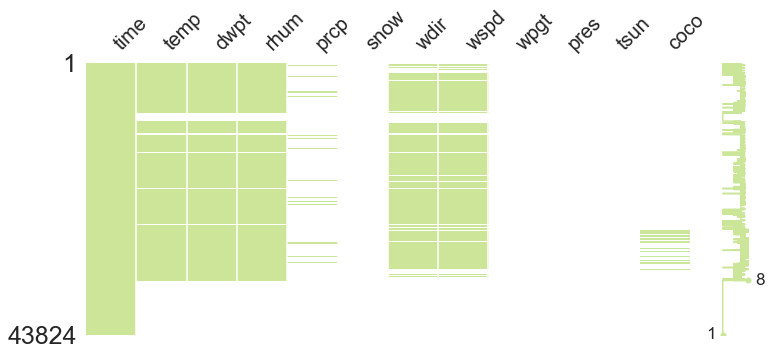

In [97]:
import missingno as msno
%matplotlib inline
msno.matrix(hourly_weather.sort_values('time'), fontsize=20, figsize=(12,5), color=(0.8, 0.9, .6))

# Values are sorted by time, missing values occur at certain times due to outages

#### Missing findings
The hourly weather data have a high degree of missingness.  Temperature (temp), dewpoint (dwpt), and relative humidity (rhum) can be used with confidence. The ppecipitation field can be used, it will be assumed that missing values record 0 precipitation.

Next steps are to subset the columns, clarify names, and check data types.

In [143]:

take_col = ['time', 'temp', 'dwpt', 'rhum', 'prcp']
hourly_weather_sub = pd.DataFrame(hourly_weather, columns=take_col)


#rename columns for clarity
hourly_weather_sub=hourly_weather_sub.rename(columns={"temp": "temp_celsius", "dwpt": "dew_pnt", "rhum": "rel_humidity", "prcp": "prcp_mm"})

#flag missing values to  track imputed rows
# True are measured, false will be imputed later
hourly_weather_sub['temp_celsius_measured']=hourly_weather_sub['temp_celsius'].notna()

hourly_weather_sub['dew_pnt_measured']=hourly_weather_sub['dew_pnt'].notna()

hourly_weather_sub['rel_humidity_measured']=hourly_weather_sub['rel_humidity'].notna()



#add month,week,day for imputing
hourly_weather_sub['month']=hourly_weather_sub['time'].dt.month
hourly_weather_sub['day']=hourly_weather_sub['time'].dt.day
hourly_weather_sub['hour']=hourly_weather_sub['time'].dt.hour

# replace missing precipitation
hourly_weather_sub['prcp_mm'] = hourly_weather_sub['prcp_mm'].fillna(0)


#substitute temperature using mean method.  We will fill other missing values with regression
hourly_weather_sub['temp_celsius'] = hourly_weather_sub.groupby(['month', 'day','hour'])['temp_celsius']\
    .transform(lambda x: x.fillna(x.mean()))

#drop extraneous columns
hourly_weather_sub=hourly_weather_sub.drop(['month', 'day','hour'], axis = 1)


hourly_weather_sub.head()
#hourly_weather_sub.info()



time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2017-01-01 00:00:00          -6.0    -12.9          58.0      0.0   
1 2017-01-01 01:00:00          -6.0    -12.9          58.0      0.0   
2 2017-01-01 02:00:00          -6.0    -12.9          58.0      0.0   
3 2017-01-01 03:00:00          -7.0    -11.9          68.0      0.0   
4 2017-01-01 04:00:00          -7.0    -13.1          62.0      0.0   

   temp_celsius_measured  dew_pnt_measured  rel_humidity_measured  
0                   True              True                   True  
1                   True              True                   True  
2                   True              True                   True  
3                   True              True                   True  
4                   True              True                   True

In [144]:
import plotly.express as px
def custom_legend_name(new_names):
    for i, new_name in enumerate(new_names):
        fig.data[i].name = new_name

fig = px.scatter(x = hourly_weather_sub['time'] ,
              y = hourly_weather_sub['temp_celsius'],
              title = 'Temperature (Celsius) vs. Time',
             color=hourly_weather_sub['temp_celsius_measured'])
custom_legend_name(['measured','mean imputed'])


fig.show()

### Weather Data Replace NA

Now that all rows have a temperature value we will impute an estimate for dew point and relative humidity

In [145]:
#count missing
print(hourly_weather_sub.isnull().sum())

time                         0
temp_celsius                 0
dew_pnt                  11023
rel_humidity             11023
prcp_mm                      0
temp_celsius_measured        0
dew_pnt_measured             0
rel_humidity_measured        0
dtype: int64


In [146]:
# Check to correlation between temperature and the other variables
hourly_weather_sub[["temp_celsius", "dew_pnt", "rel_humidity", "prcp_mm"]].corr()

temp_celsius   dew_pnt  rel_humidity   prcp_mm
temp_celsius      1.000000  0.590181     -0.572269  0.087600
dew_pnt           0.590181  1.000000      0.281904  0.195059
rel_humidity     -0.572269  0.281904      1.000000  0.099130
prcp_mm           0.087600  0.195059      0.099130  1.000000

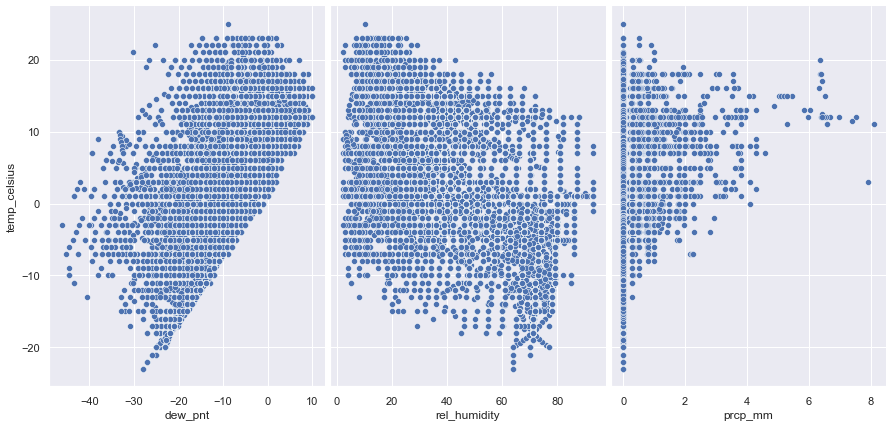

In [147]:
# visualize the relationship between the features and the Temperature (Celsius) using scatterplots
sns.pairplot(hourly_weather_sub, x_vars=['dew_pnt','rel_humidity','prcp_mm'], y_vars='temp_celsius', height=6, aspect=0.7)

## Weather observations

Temperature is positively correlated with dew point and negatively correlated with relative humidity.  Relative humidity is higher in colder weather.  Looking at the Plots this relationship can be observed but there's high variability in the data.  Also, there appears to be a uniform overprint in the relative humidty plot.  This is due to us selecting the normalization and interpolation options when we imported the data.  The source of the weather data already did some interpolation of missing values which is creating the observed trend.  We will fit a linear model to "impute" missing values for relative humidity and dew point.


In [148]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Temperature is the most complete

# create model of dew point given temperature and precipitation
dew_mod = ols("dew_pnt ~ temp_celsius+ prcp_mm+ prcp_mm*temp_celsius", data=hourly_weather_sub).fit()

dew_model_summary = dew_mod.summary()
dew_model_summary



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dew_pnt   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     6370.
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        11:35:37   Log-Likelihood:            -1.0525e+05
No. Observations:               32801   AIC:                         2.105e+05
Df Residuals:                   32797   BIC:                         2.105e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -9.8852      0.035   -281.864      0.000      -9.954      -9.817
temp_celsius             0.4860      0.004    130.214      0.000       0.479       0.493
prcp_mm                  3.2783      0.174     18.836      0.000       2.937       3.619
prcp_mm:temp_celsius    -0.0253      0.016     -1.534      0.125      -0.058       0.007
==============================================================================
Omnibus:                     6930.686   Durbin-Watson:                   0.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16597.875
Skew:                          -1.182   Prob(JB):                         0.00
Kurtosis:                       5.560   Cond. No.                         49.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

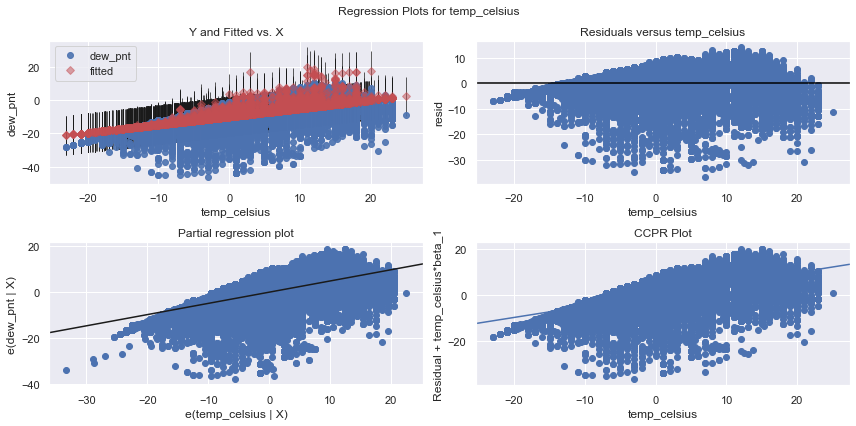

In [149]:
import statsmodels

fig = plt.figure(figsize=(12,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(dew_mod, "temp_celsius", fig=fig)

In [150]:
# Create humidity model
# create model of dew point given temperature and precipitation
rel_humid_mod = ols("rel_humidity ~ temp_celsius+ prcp_mm+ prcp_mm*temp_celsius", data=hourly_weather_sub).fit()

rel_humid_summary = rel_humid_mod.summary()
rel_humid_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rel_humidity   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5917.
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        11:35:43   Log-Likelihood:            -1.4116e+05
No. Observations:               32801   AIC:                         2.823e+05
Df Residuals:                   32797   BIC:                         2.824e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               53.5751      0.105    511.115      0.000      53.370      53.781
temp_celsius            -1.4508      0.011   -130.068      0.000      -1.473      -1.429
prcp_mm                 11.3299      0.520     21.781      0.000      10.310      12.349
prcp_mm:temp_celsius    -0.1718      0.049     -3.490      0.000      -0.268      -0.075
==============================================================================
Omnibus:                      448.816   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.121
Skew:                          -0.273   Prob(JB):                     4.04e-99
Kurtosis:                       2.816   Cond. No.                         49.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

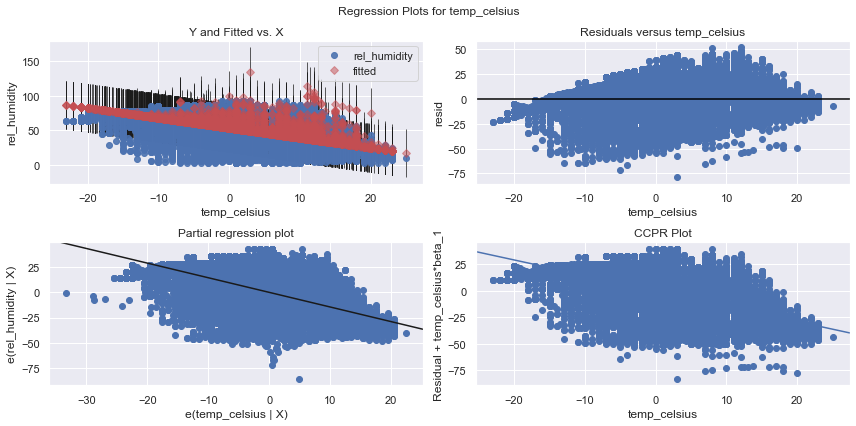

In [151]:
#Evaluate the rel humidity model 
fig = plt.figure(figsize=(12,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(rel_humid_mod, "temp_celsius", fig=fig)

In [152]:


# create predictions for dew point and relative humidity

hourly_weather_sub['pred_dwpnt']=dew_mod.predict(hourly_weather_sub)

hourly_weather_sub['pred_rhum']=rel_humid_mod.predict(hourly_weather_sub)


hourly_weather_sub.head()

time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2017-01-01 00:00:00          -6.0    -12.9          58.0      0.0   
1 2017-01-01 01:00:00          -6.0    -12.9          58.0      0.0   
2 2017-01-01 02:00:00          -6.0    -12.9          58.0      0.0   
3 2017-01-01 03:00:00          -7.0    -11.9          68.0      0.0   
4 2017-01-01 04:00:00          -7.0    -13.1          62.0      0.0   

   temp_celsius_measured  dew_pnt_measured  rel_humidity_measured  pred_dwpnt  \
0                   True              True                   True  -12.801102   
1                   True              True                   True  -12.801102   
2                   True              True                   True  -12.801102   
3                   True              True                   True  -13.287077   
4                   True              True                   True  -13.287077   

   pred_rhum  
0  62.280143  
1  62.280143  
2  62.280143  
3  63.730992  
4  63.730992

<AxesSubplot:xlabel='pred_dwpnt', ylabel='dew_pnt'>

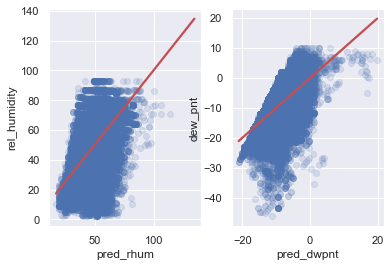

In [153]:
#Create Predicted vs actual plotfor relative humidity (left) and dew point (right)

fig, ax =plt.subplots(1,2)

sns.regplot(x='pred_rhum', y='rel_humidity', data=hourly_weather_sub, line_kws = {"color":"r"}, 
            ci=None,scatter_kws={'alpha':0.15},ax=ax[0])

sns.regplot(x='pred_dwpnt', y='dew_pnt', data=hourly_weather_sub, line_kws = {"color":"r"},
            scatter_kws={'alpha':0.15}, ci=None,ax=ax[1] )



In [159]:


#fill missing rel humidity values with predictions
hourly_weather_sub['dew_pnt'] = hourly_weather_sub['dew_pnt'].fillna(hourly_weather_sub['pred_dwpnt'])

# fill missing dew point values with predictions
hourly_weather_sub['rel_humidity'] = hourly_weather_sub['rel_humidity'].fillna(hourly_weather_sub['pred_rhum'])

#take relevant columns
hourly_weather_final = hourly_weather_sub.drop(['pred_dwpnt', 'pred_rhum','dew_pnt_measured','rel_humidity_measured'], axis = 1)


#print 
hourly_weather_final.head()


time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2017-01-01 00:00:00          -6.0    -12.9          58.0      0.0   
1 2017-01-01 01:00:00          -6.0    -12.9          58.0      0.0   
2 2017-01-01 02:00:00          -6.0    -12.9          58.0      0.0   
3 2017-01-01 03:00:00          -7.0    -11.9          68.0      0.0   
4 2017-01-01 04:00:00          -7.0    -13.1          62.0      0.0   

   temp_celsius_measured  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [160]:
#Check for complete data

print("Missing values post imputation")
print(hourly_weather_final.isnull().sum())



Missing values post imputation
time                     0
temp_celsius             0
dew_pnt                  0
rel_humidity             0
prcp_mm                  0
temp_celsius_measured    0
dtype: int64


## Combine Hourly Traffic and weather data

In [181]:
hourly_data_combined =pd.merge(
                   hourly_traffic_full,
                   hourly_weather_final,
                   how="left",
                   left_on=['count_datetime'],
                   right_on=['time']
)
#drop 
hourly_data_combined=hourly_data_combined.drop(['time'], axis = 1)

#rearrange columns
cols = hourly_data_combined.columns.tolist()
cols = ['count_date',
    'count_datetime',
    'direction',
    'month',
    'week',
    'hour',
    'vehicles_per_hour',
    'temp_celsius',
    'dew_pnt',
    'rel_humidity',
    'prcp_mm',
     'measured',
    'temp_celsius_measured']

hourly_data_combined = hourly_data_combined[cols]
# print first few rows
hourly_data_combined.head()



count_date      count_datetime direction  month  week  hour  \
0 2017-01-01 2017-01-01 00:00:00         P      1    52     0   
1 2017-01-01 2017-01-01 00:00:00         S      1    52     0   
2 2017-01-01 2017-01-01 01:00:00         P      1    52     1   
3 2017-01-01 2017-01-01 01:00:00         S      1    52     1   
4 2017-01-01 2017-01-01 02:00:00         P      1    52     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               94.0          -6.0    -12.9          58.0      0.0      True   
1               77.0          -6.0    -12.9          58.0      0.0      True   
2               75.0          -6.0    -12.9          58.0      0.0      True   
3               95.0          -6.0    -12.9          58.0      0.0      True   
4               84.0          -6.0    -12.9          58.0      0.0      True   

   temp_celsius_measured  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [182]:
print("Missing values post imputation")
print(hourly_data_combined.isnull().sum())

Missing values post imputation
count_date               0
count_datetime           0
direction                0
month                    0
week                     0
hour                     0
vehicles_per_hour        0
temp_celsius             0
dew_pnt                  0
rel_humidity             0
prcp_mm                  0
measured                 0
temp_celsius_measured    0
dtype: int64


6

## Add descriptive columns



In [305]:
# calculate the day of the year for time_series plots
hourly_data_combined['day_of_year'] = hourly_data_combined['count_date'].dt.dayofyear

#calculate day of week number (0 = Monday, 6= Sunday)
hourly_data_combined['day_of_week']=hourly_data_combined['count_date'].dt.day_of_week

# designate weekend ()
hourly_data_combined.loc[hourly_data_combined['day_of_week'] >=5, 'weekend'] = 1 
hourly_data_combined.loc[hourly_data_combined['day_of_week'] <5, 'weekend'] = 0 


# mark American holidays. Note that holidays that fall on weekedns are applied in the preceding or proceeding week.
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=hourly_data_combined['count_date'].min(),
                        end=hourly_data_combined['count_date'].max()).to_pydatetime()

#designate which days are holidays
hourly_data_combined['holiday'] = hourly_data_combined['count_date'].isin(holidays)


#check that tables look good by printing the first few rows.
hourly_data_combined.head()




count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2017-01-01 00:00:00         P 2017-01-01     0               94.0      True   
1 2017-01-01 00:00:00         S 2017-01-01     0               77.0      True   
2 2017-01-01 01:00:00         P 2017-01-01     1               75.0      True   
3 2017-01-01 01:00:00         S 2017-01-01     1               95.0      True   
4 2017-01-01 02:00:00         P 2017-01-01     2               84.0      True   

   month  week  day                time  temp_celsius  dew_pnt  rel_humidity  \
0      1    52    6 2017-01-01 00:00:00          -6.0    -12.9          58.0   
1      1    52    6 2017-01-01 00:00:00          -6.0    -12.9          58.0   
2      1    52    6 2017-01-01 01:00:00          -6.0    -12.9          58.0   
3      1    52    6 2017-01-01 01:00:00          -6.0    -12.9          58.0   
4      1    52    6 2017-01-01 02:00:00          -6.0    -12.9          58.0   

   prcp_mm  temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0      0.0                   True            1            6      1.0    False  
1      0.0                   True            1            6      1.0    False  
2      0.0                   True            1            6      1.0    False  
3      0.0                   True            1            6      1.0    False  
4      0.0                   True            1            6      1.0    False

In [306]:
#identify a random date, filter to date of interest, pull the whole week
import datetime as dt
from datetime import timedelta
import random

# select a random date, plot vehicle counts for that day.
min_date= hourly_data_combined['count_date'].min()
max_date= hourly_data_combined['count_date'].max()


#set seed
random.seed(12)

#get random date between the min and max for the dataset 
time_between_dates = max_date - min_date
days_between_dates = time_between_dates.days
random_number_of_days = random.randrange(days_between_dates)
random_date = min_date + timedelta(days=random_number_of_days)

#random day in the data
random_date

#get day of week, create lower and upper bound for filter to 1 random week
#Monday is 0, Sunday is 6
random_day_of_week=  random_date.day_of_week
day_to_add= 6-random_day_of_week
day_to_sub= 0+random_day_of_week
#
#day_to_add
#day_to_sub


#create lower and upper bound filter
upper_bound= random_date + timedelta(days=day_to_add)
#upper_bound

lower_bound= random_date - timedelta(days=day_to_sub)
#lower_bound

#set mask for date filter
mask = (hourly_data_combined['count_date'] >= lower_bound) & (hourly_data_combined['count_date'] <= upper_bound)

#filter data to 1 random week
#print("The first table is for one week that contains our random day ")
one_week = hourly_data_combined.loc[mask]
#print(one_week.head())
#print(one_week.shape)

#filter data to 1 random day
print("The second tables is for one random day ")
one_day= hourly_data_combined.loc[hourly_data_combined['count_date'] == random_date]

one_day.head()

The second tables is for one random day 


count_datetime direction count_date  hour  vehicles_per_hour  \
46608 2019-08-30 00:00:00         P 2019-08-30     0              107.0   
46609 2019-08-30 00:00:00         S 2019-08-30     0              258.0   
46610 2019-08-30 01:00:00         P 2019-08-30     1               87.0   
46611 2019-08-30 01:00:00         S 2019-08-30     1              193.0   
46612 2019-08-30 02:00:00         P 2019-08-30     2               85.0   

       measured  month  week  day                time  temp_celsius  dew_pnt  \
46608      True      8    35    4 2019-08-30 00:00:00          15.0     -2.0   
46609      True      8    35    4 2019-08-30 00:00:00          15.0     -2.0   
46610      True      8    35    4 2019-08-30 01:00:00          15.0     -2.0   
46611      True      8    35    4 2019-08-30 01:00:00          15.0     -2.0   
46612      True      8    35    4 2019-08-30 02:00:00          13.0     -2.9   

       rel_humidity  prcp_mm  temp_celsius_measured  day_of_year  day_of_week  \
46608          31.0      0.0                   True          242            4   
46609          31.0      0.0                   True          242            4   
46610          31.0      0.0                   True          242            4   
46611          31.0      0.0                   True          242            4   
46612          33.0      0.0                   True          242            4   

       weekend  holiday  
46608      0.0    False  
46609      0.0    False  
46610      0.0    False  
46611      0.0    False  
46612      0.0    False

### Create Plots to examine daily and weekly trends

Now that the data are mined and confirmed to be in good order with minimal missingness we want to get  a feel for any cyclicity in the data.  Traffic counts are a product of road usage.  Given the location of the Eisehower tunnel we will geta  good sense of when people are accessing the mountains.  I70 is a busy interstate and through traffic will be a major component of daily use; however, residents of the front range will drive through the tunnel to access mountain recreation.  We should then expect heavy usage during certain seasons, weekends, and holidays.  We will now examine a random day and random week for patterns in the data.  We will include direction to get a feel for when day-trippers may be returning home from the mountains.


This is a  daily plot for a  random day with direction 


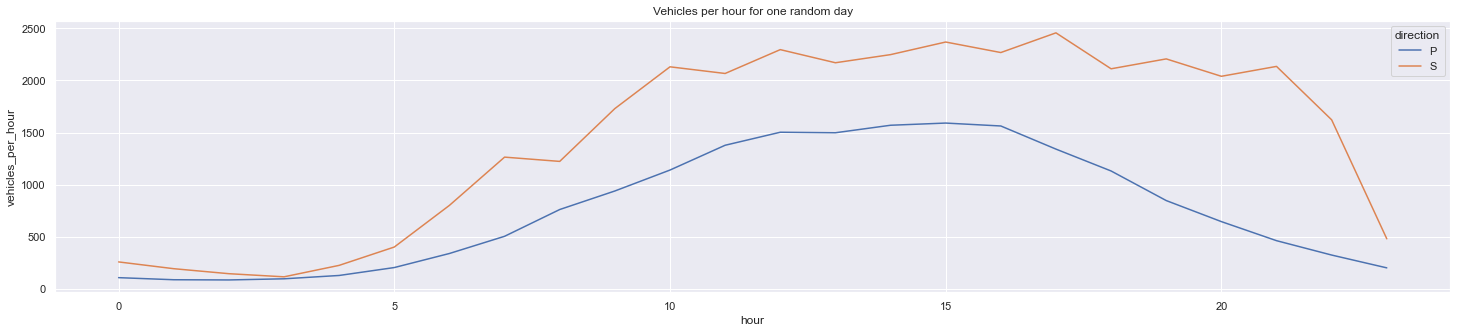

In [201]:
# Daily Plot

print("This is a  daily plot for a  random day with direction ")
sns.lineplot(data=one_day, x="hour", y="vehicles_per_hour", hue="direction").set(
    title="Vehicles per hour for one random day")

sns.set(rc = {'figure.figsize':(10,8)})

In [307]:
# weekly plot random week

#Plot traffic counts vs date 
import plotly.express as px


fig = px.line( x = one_week['count_datetime'] ,
              y = one_week['vehicles_per_hour'],
              color=one_week['direction'],
              title = 'Daily Traffic Counts for a Random  Week')
fig.show()

The patterns observed in this random week from monday to Sunday are typical.  Traffic directions, indicated as "primary" and "secondary" refer to east and westbound traffic respectively.  Resident on the front Range drive west (secondary, "s") to access the mountains.  Each day westward traffic spike around 8 AM and eastbound traffic peaks in the PM.  There is elevated westward traffic on Friday and a large influx Sunday afternoon.
Next we will generate daily totals for all days in the data set.  We will also identify days that fall on weekedns and holidays.



# Data Exploration

## Questions to be considered

1) When is traffic the heaviest?
2) On average what is the busiest day of the week?
3) How does East and West Traffic compare?
4) What is the effect of holidays on traffic counts?
5) What is the effect of precipitation on traffic counts?
6) What are the total traffic counts for each year? What are the trends?
7) Which months and days have the highest traffic counts?
8) What was the impact of the 2020 pandemic on traffic counts?



In [ ]:
#ax = sns.heatmap(df, cmap='RdYlGn_r',
#                 robust=True,
#                 fmt='.2f',
#                 annot=True,
#                 linewidths=.5,
#                 annot_kws={'size':11},
#                 cbar_kws={'shrink':.8,
#                           'label':'Precipitation(mm)'})                       
#    
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
#plt.title('Average Precipitations', fontdict={'fontsize':18},    pad=14);

In [308]:
# Check out a correlation plot.  If vehicles per hour is our desired response variable, non of the independent vairables have a strong linear relationship

hourly_data_combined[["vehicles_per_hour","day_of_week","day_of_year", "hour","temp_celsius", "dew_pnt", "rel_humidity", "prcp_mm"]].corr()

vehicles_per_hour   day_of_week   day_of_year  \
vehicles_per_hour           1.000000  1.778164e-01 -7.143558e-03   
day_of_week                 0.177816  1.000000e+00  1.419409e-03   
day_of_year                -0.007144  1.419409e-03  1.000000e+00   
hour                        0.279917 -2.369147e-17 -2.041469e-15   
temp_celsius                0.002359  5.541211e-03  2.247237e-01   
dew_pnt                     0.017359  1.680190e-02  9.787352e-02   
rel_humidity                0.002573  5.808810e-03 -1.725598e-01   
prcp_mm                    -0.035468  1.442883e-02  1.533875e-02   

                           hour  temp_celsius   dew_pnt  rel_humidity  \
vehicles_per_hour  2.799165e-01      0.002359  0.017359      0.002573   
day_of_week       -2.369147e-17      0.005541  0.016802      0.005809   
day_of_year       -2.041469e-15      0.224724  0.097874     -0.172560   
hour               1.000000e+00      0.090516 -0.001896     -0.108632   
temp_celsius       9.051567e-02      1.000000  0.637184     -0.622124   
dew_pnt           -1.895629e-03      0.637184  1.000000      0.168392   
rel_humidity      -1.086317e-01     -0.622124  0.168392      1.000000   
prcp_mm            5.973499e-02      0.087520  0.190240      0.091980   

                    prcp_mm  
vehicles_per_hour -0.035468  
day_of_week        0.014429  
day_of_year        0.015339  
hour               0.059735  
temp_celsius       0.087520  
dew_pnt            0.190240  
rel_humidity       0.091980  
prcp_mm            1.000000

In [237]:
# time and day trends
# get the mean for the data by hour and day

#hourly_data_combined_heat  =  hourly_data_combined[['vehicles_per_hour','month', 'day_of_week', 'hour']]


hourly_data_combined.head()

count_date      count_datetime direction  month  week  hour  \
0 2017-01-01 2017-01-01 00:00:00         P      1    52     0   
1 2017-01-01 2017-01-01 00:00:00         S      1    52     0   
2 2017-01-01 2017-01-01 01:00:00         P      1    52     1   
3 2017-01-01 2017-01-01 01:00:00         S      1    52     1   
4 2017-01-01 2017-01-01 02:00:00         P      1    52     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               94.0          -6.0    -12.9          58.0      0.0      True   
1               77.0          -6.0    -12.9          58.0      0.0      True   
2               75.0          -6.0    -12.9          58.0      0.0      True   
3               95.0          -6.0    -12.9          58.0      0.0      True   
4               84.0          -6.0    -12.9          58.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            6      1.0    False  
1                   True            1            6      1.0    False  
2                   True            1            6      1.0    False  
3                   True            1            6      1.0    False  
4                   True            1            6      1.0    False

hour                  0           1          2          3           4  \
day_of_week                                                             
0            124.868765   90.172583  75.563350  82.395529  127.177596   
1            107.552520   83.514215  69.739090  74.022477  103.690853   
2            113.578931   85.520762  73.368502  78.880020  110.204412   
3            130.793851   99.710298  85.311558  88.772285  118.624806   
4            143.531669  111.077660  87.882022  91.393265  122.689666   

hour                  5           6           7           8            9  \
day_of_week                                                                
0            264.392918  506.828972  749.959206  918.478911  1082.849689   
1            205.559131  391.189023  616.981846  777.213042   903.422620   
2            212.469092  400.511551  635.277764  802.599640   938.781803   
3            222.867208  412.828629  654.881780  837.629015   982.461009   
4            220.862137  432.563826  737.602727  943.047553  1123.805872   

hour                  10           11           12           13           14  \
day_of_week                                                                    
0            1215.154795  1236.557434  1187.560663  1196.092996  1190.624160   
1             981.840586   988.551398   973.734948  1002.674879  1053.486197   
2            1027.635598  1026.844900  1022.200545  1064.040182  1130.311227   
3            1083.560936  1124.056034  1125.523925  1168.625448  1252.597239   
4            1288.023640  1369.081873  1414.816047  1529.813113  1637.946510   

hour                  15           16           17           18           19  \
day_of_week                                                                    
0            1146.502861  1078.637016   906.432928   707.324855   547.612933   
1            1053.926014   997.900905   844.489044   649.346582   508.514927   
2            1139.171921  1064.246909   905.783884   721.690487   576.738149   
3            1263.053097  1228.926074  1079.521990   871.988753   719.986968   
4            1665.051187  1659.453719  1551.576519  1327.832919  1100.221530   

hour                 20          21          22          23         All  
day_of_week                                                              
0            410.654840  292.803748  204.857190  153.132391  645.693180  
1            391.018197  295.225550  213.897807  154.016716  560.062857  
2            442.191128  334.748679  238.353206  177.612309  596.781733  
3            556.201822  411.485891  284.790441  201.291525  666.895441  
4            847.270427  569.926261  369.290215  248.647889  858.058677

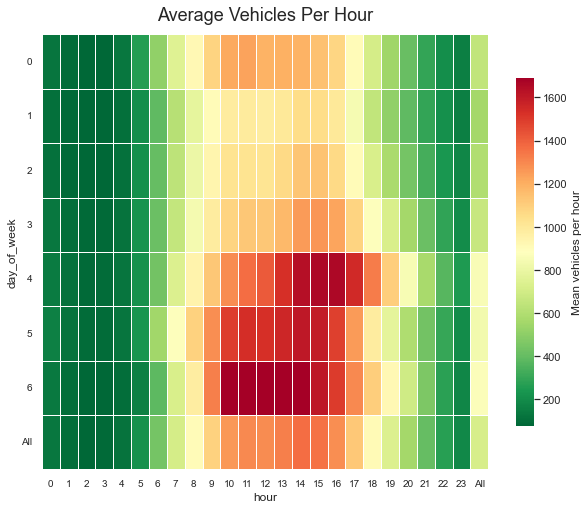

In [365]:
#Get averages by day of week and time

all_hours_day_df = pd.pivot_table(data= hourly_data_combined[['vehicles_per_hour', 'day_of_week', 'hour']], 
                                  values="vehicles_per_hour",
                                   index="day_of_week",
                                  columns="hour",
                                  margins=True
                                   )
#print(all_hours_day_df.head(7))


ax = sns.heatmap(all_hours_day_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Vehicles Per Hour', fontdict={'fontsize':18},    pad=14);

#type(hourly_data_combined_heat)

The heat map above has the average traffic counts for Eisenhower tunnel for both the East and West bound lanes combined.  The pattern is clear, the 5-6 (0 index) days of the week, Friday-Sunday have the highest traffic counts.  The average values for Sunday afternoon are > 1600 cars per hour, or 1 car every 2 seconds.  Next we will examine the average effects between each month. 

In [407]:
#divide data into east and westbound
#compare Primary  and Secondary
hourly_data_combined_primary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['P'])]
all_hours_day_df_primary = pd.pivot_table(data= hourly_data_combined_primary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )
#all_hours_day_df_primary.head()




#compare Primary  and Secondary
hourly_data_combined_secondary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['S'])]
all_hours_day_df_secondary = pd.pivot_table(data= hourly_data_combined_secondary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )
#all_hours_day_df_secondary.head()
hourly_data_combined_secondary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['S'])]
all_hours_day_df_secondary = pd.pivot_table(data= hourly_data_combined_secondary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )


hourly_data_combined_secondary.head(3)




count_datetime direction count_date  hour  vehicles_per_hour  measured  \
1 2017-01-01 00:00:00         S 2017-01-01     0               77.0      True   
3 2017-01-01 01:00:00         S 2017-01-01     1               95.0      True   
5 2017-01-01 02:00:00         S 2017-01-01     2               77.0      True   

   month  week  day                time  temp_celsius  dew_pnt  rel_humidity  \
1      1    52    6 2017-01-01 00:00:00          -6.0    -12.9          58.0   
3      1    52    6 2017-01-01 01:00:00          -6.0    -12.9          58.0   
5      1    52    6 2017-01-01 02:00:00          -6.0    -12.9          58.0   

   prcp_mm  temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
1      0.0                   True            1            6      1.0    False  
3      0.0                   True            1            6      1.0    False  
5      0.0                   True            1            6      1.0    False

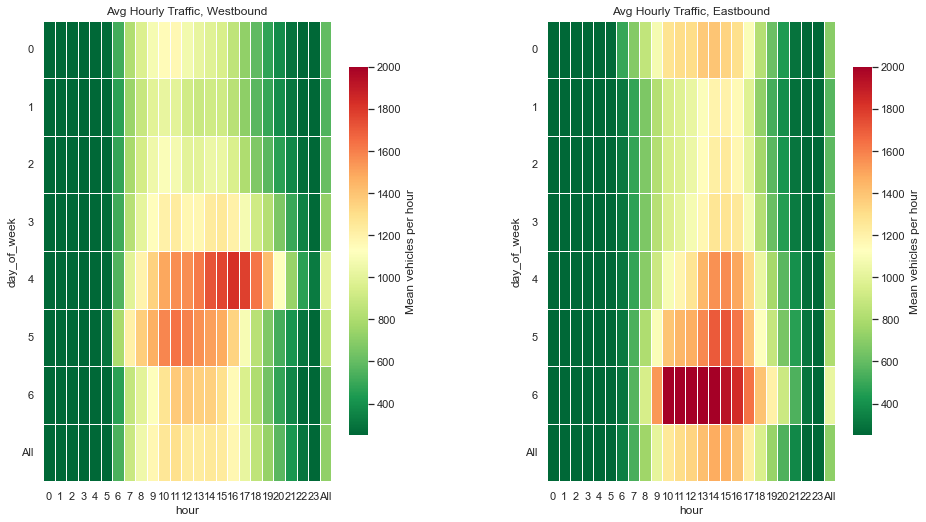

In [416]:

#
#Color maps comparing east and westbound traffic

import numpy as np; np.random.seed(0)
import seaborn as sns

#all_hours_day_df_secondary   
#all_hours_day_df_primary 

fig, ax =plt.subplots(1,2)

sns.heatmap(all_hours_day_df_secondary, ax=ax[0],cmap='RdYlGn_r',
                 robust=True,
                 vmin=250,
                 vmax=2000,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})
sns.heatmap(all_hours_day_df_primary, ax=ax[1],cmap='RdYlGn_r',
             vmin=250,
                 vmax=2000,
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'}           
           )
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax[0].title.set_text('Avg Hourly Traffic, Westbound')
ax[1].title.set_text('Avg Hourly Traffic, Eastbound')
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0, fontsize=11)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0, fontsize=11)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0, fontsize=11)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, fontsize=11)
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

Two heatmaps showing the average traffic count for each hour on each day of the week.  Traffic counts are highest 7:00-6:00 on each day of the week.  Westbound traffic is heavier earlier in the day than eastbound traffic.  The heaviest westbound traffic is on Friday and Saturday, the highest eastbound traffic is on Sunday as commuters return to Denver.

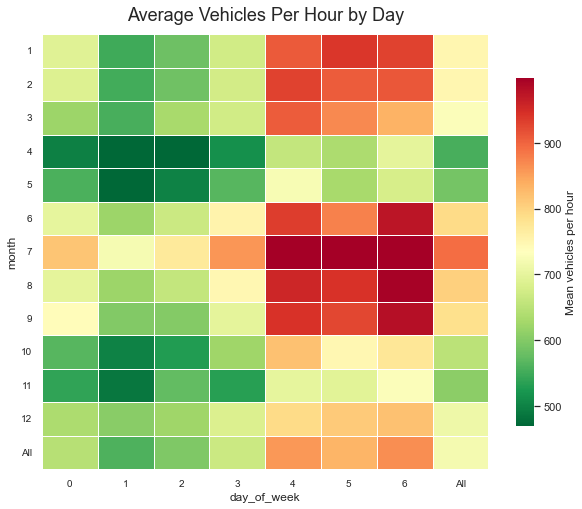

In [310]:
#Get averages by day of week and time

all_months_weeks = pd.pivot_table(data= hourly_data_combined[['vehicles_per_hour', 'month', 'day_of_week']], 
                                  values="vehicles_per_hour",
                                   index="month",
                                  columns="day_of_week",
                                  margins=True
                                   )
#print(all_hours_day_df.head(7))


ax = sns.heatmap(all_months_weeks, cmap='RdYlGn_r',
                
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Vehicles Per Hour by Day', fontdict={'fontsize':18},    pad=14);


#type(hourly_data_combined_heat)

The heat map shows the average hourly traffic counts by month for each day of the week.  The averages are much lower than those above because the daily values include all of the low traffic hours in the early morning.  Friday through Sunday are high traffic days in nearly every month.  Traffic is elevated during the ski season, January-March, and during the Summer.  Interestingly the week of fourth of July sees elevated traffic on weekdays.  This is likely due to when the July 4th holiday falls in a given year.  Overall Winter and Summer have the most traffic with reduced traffic in the Fall and Spring.  Traffic is higher in the fall than in the spring.  On average the best day and month to travel is a Tuesday in April or May. One would expect very high traffic on a Saturday afternoon in July.

### Daily totals


In [311]:
hourly_data_combined.head(2)



count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0     2017-01-01         P 2017-01-01     0               94.0      True   
1     2017-01-01         S 2017-01-01     0               77.0      True   

   month  week  day       time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0      1    52    6 2017-01-01          -6.0    -12.9          58.0      0.0   
1      1    52    6 2017-01-01          -6.0    -12.9          58.0      0.0   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            6      1.0    False  
1                   True            1            6      1.0    False

In [423]:
#compile data to the day.  

fixed_values= hourly_data_combined[["count_date", "month", "week",  "measured",'direction', "temp_celsius_measured", "day_of_week", "weekend", "holiday"]]
fixed_values=fixed_values.drop_duplicates(subset=['count_date', 'direction'], keep='last')


#values to sum
day_values_sum = hourly_data_combined[["count_date", "vehicles_per_hour", "direction","prcp_mm"  ]]
daily_traffic  =  day_values_sum.groupby(['count_date', 'direction']).sum()
daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})



# columns to mean
day_values_mean = hourly_data_combined[["count_date",  "temp_celsius",  "dew_pnt" , "rel_humidity"]]
day_values_mean=day_values_mean.groupby('count_date').mean()

#join sums and fixed header data
daily_data_combined= pd.merge(
    daily_traffic,
    fixed_values,
    how='left',
    on= ['count_date','direction']

)
#
# add pertinent headers
daily_data_combined['day_of_year'] = daily_data_combined['count_date'].dt.dayofyear
daily_data_combined['year'] = daily_data_combined['count_date'].dt.year


daily_data_combined= pd.merge(
    daily_data_combined,
    day_values_mean,
    how='left',
    on= ['count_date']

)


#join with mean data

print(daily_data_combined.shape)
daily_data_combined.head()


(3650, 16)


count_date direction  vehicles_per_day  prcp_mm  month  week  measured  \
0 2017-01-01         P           26915.0      0.0      1    52      True   
1 2017-01-01         S           18438.0      0.0      1    52      True   
2 2017-01-02         P           29040.0      0.0      1     1      True   
3 2017-01-02         S           20069.0      0.0      1     1      True   
4 2017-01-03         P           14245.0      0.0      1     1      True   

   temp_celsius_measured  day_of_week  weekend  holiday  day_of_year  year  \
0                   True            6      1.0    False            1  2017   
1                   True            6      1.0    False            1  2017   
2                   True            0      0.0     True            2  2017   
3                   True            0      0.0     True            2  2017   
4                   True            1      0.0    False            3  2017   

   temp_celsius    dew_pnt  rel_humidity  
0     -7.708333 -13.360417     64.770833  
1     -7.708333 -13.360417     64.770833  
2     -6.833333 -13.435417     59.812500  
3     -6.833333 -13.435417     59.812500  
4     -8.791667 -14.608333     63.916667

In [335]:
daily_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650 entries, 0 to 3649
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   count_date             3650 non-null   datetime64[ns]
 1   direction              3650 non-null   object        
 2   vehicles_per_day       3650 non-null   float64       
 3   prcp_mm                3650 non-null   float64       
 4   month                  3650 non-null   int64         
 5   week                   3650 non-null   UInt32        
 6   measured               3650 non-null   bool          
 7   temp_celsius_measured  3650 non-null   bool          
 8   day_of_week            3650 non-null   int64         
 9   weekend                3650 non-null   float64       
 10  holiday                3650 non-null   bool          
 11  day_of_year            3650 non-null   int64         
 12  year                   3650 non-null   int64         
 13  tem

In [424]:
# Plot time series of all data

#Plot Temperature vs date 
import plotly.express as px


fig = px.line( x = daily_data_combined['count_date'] ,
              y = daily_data_combined['vehicles_per_day'],
              color=daily_data_combined['direction'],
              title = 'Daily Traffic Counts for years of interest')
fig.show()

<AxesSubplot:xlabel='day_of_year', ylabel='vehicles_per_day'>

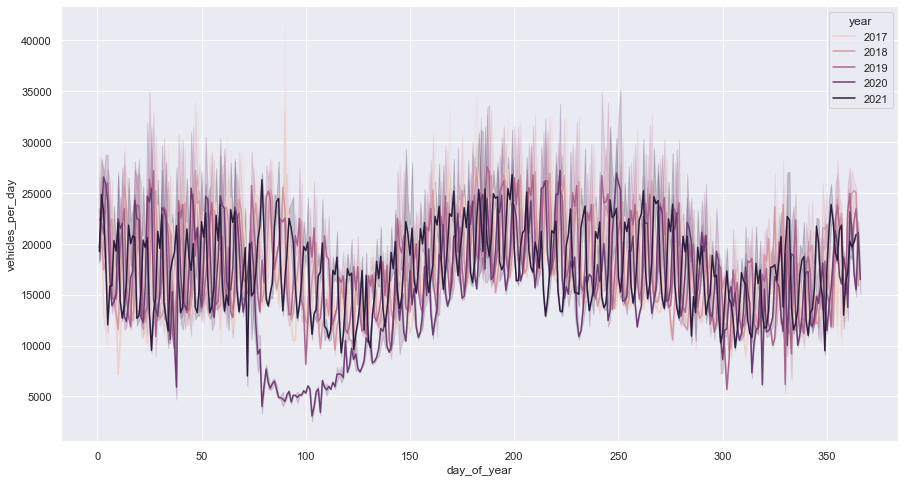

In [430]:
# get value counts for each year.
#Plot standardized to day of year Broken out by year
sns.lineplot(data=daily_data_combined, x="day_of_year", y="vehicles_per_day", hue="year")


In [461]:
# totals regardless of direction

daily_totals= daily_data_combined[["day_of_year","vehicles_per_day","year"]]
daily_totals = daily_totals.groupby(["year", "day_of_year"]).sum()
daily_totals.head()


vehicles_per_day
year day_of_year                  
2017 1                     45353.0
     2                     49109.0
     3                     26790.0
     4                     23726.0
     5                     22522.0

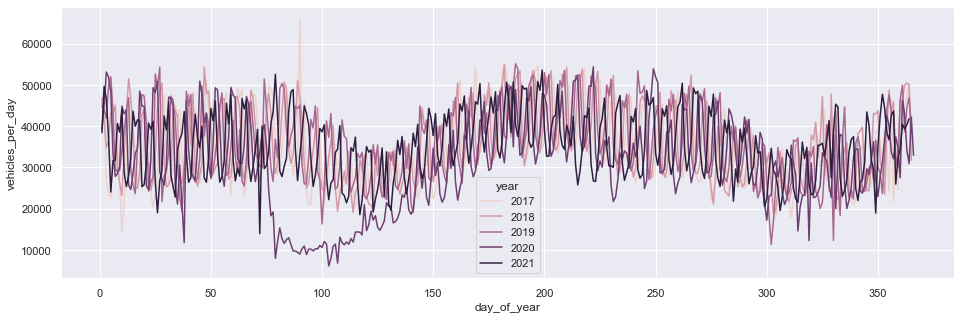

In [472]:
sns.lineplot(data=daily_totals, x="day_of_year", y="vehicles_per_day", hue="year")
sns.set(rc = {'figure.figsize':(16,5)})

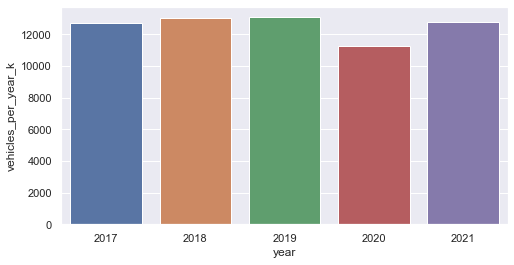

In [470]:
import seaborn as sns
import matplotlib.pyplot as plt

yearly_totals= daily_data_combined[[ 'vehicles_per_day','year' ]]
yearly_totals = yearly_totals.groupby('year').sum()/1000

yearly_totals=yearly_totals.rename(columns={"vehicles_per_day": "vehicles_per_year_k"})
yearly_totals.head()

#
# barplot annual totals
sns.barplot(x = yearly_totals.index,
            y = yearly_totals['vehicles_per_year_k'])
 
sns.set(rc = {'figure.figsize':(8,4)})